# EMG spectrogram visualization

This notebook shows how to compute the spectrogram of the EMG samples capture by the Myo armband.

NOTE: you need to install the additional library `librosa` to generate the spectrogram plot.

In [86]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import math
import pandas as pd

In [87]:
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(len(specgram), 1, figsize=(16, 8))

    axs[0].set_title(title or "Spectrogram (db)")

    for i, spec in enumerate(specgram):
        im = axs[i].imshow(librosa.power_to_db(specgram[i]), origin="lower", aspect="auto")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    axs[i].set_xlabel("Frame number")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

def plot_signal(signal, title=None, ylabel="time"):
    fig, axs = plt.subplots(len(signal), 1, figsize=(16, 8))

    axs[0].set_title(title or "EMG signal")

    for i, sig in enumerate(signal):
        im = axs[i].plot(range(len(sig)), sig)
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    axs[i].set_xlabel("time")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

def plot_general(signal):
    plt.plot(signal)
    plt.show()


In [88]:
# Sampling frequency is 160 Hz
# With 32 samples the frequency resolution after FFT is 160 / 32

n_fft = 510
win_length = None
hop_length = 1

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)


def compute_spectrogram(signal, title):
    freq_signal = [spectrogram(signal[:, i]) for i in range(8)]
    plot_spectrogram(freq_signal, title=title)
    return freq_signal

In [89]:
# Replace with your path to one of the subjects from Action-Net
emg_annotations = pd.read_pickle("../../an_data/EMG/S00_2.pkl")

sample_no = 4
signal = torch.from_numpy(emg_annotations.iloc[sample_no].myo_left_readings).float()
title = emg_annotations.iloc[sample_no].description

In [90]:
emg_annotations.iloc[sample_no]

description                                               Peel a cucumber
start                                                   1654640311.804312
stop                                                     1654640351.35253
myo_left_timestamps     [1654640311.8078036, 1654640311.811295, 165464...
myo_left_readings       [[-4, -2, 5, -1, 2, 1, -1, -4], [-3, 9, -3, 3,...
myo_right_timestamps    [1654640311.8053136, 1654640311.816281, 165464...
myo_right_readings      [[-19, -5, 2, 3, -17, 3, 28, -8], [13, 0, 6, 1...
Name: 4, dtype: object

In [96]:
dur = emg_annotations.iloc[sample_no].stop - emg_annotations.iloc[sample_no].start
print(f"The action last {dur} s")
print(f"The sampling frequency is 160Hz, so we have {dur*160} samples")
print(f"Left: {len(emg_annotations.iloc[sample_no].myo_left_readings)}")
print(f"Right: {len(emg_annotations.iloc[sample_no].myo_right_readings)}")
# Eccedono, bisogna croppare, io direi di farlo subito


The action last 39.54821801185608 s
The sampling frequency is 160Hz, so we have 6327.714881896973 samples
Left: 6275
Right: 6386


In [97]:
n_clip = 5
dur_clip = math.floor(dur*160/n_clip)

print(f"Each clip has {math.floor(dur_clip)} samples")

Each clip has 1265 samples


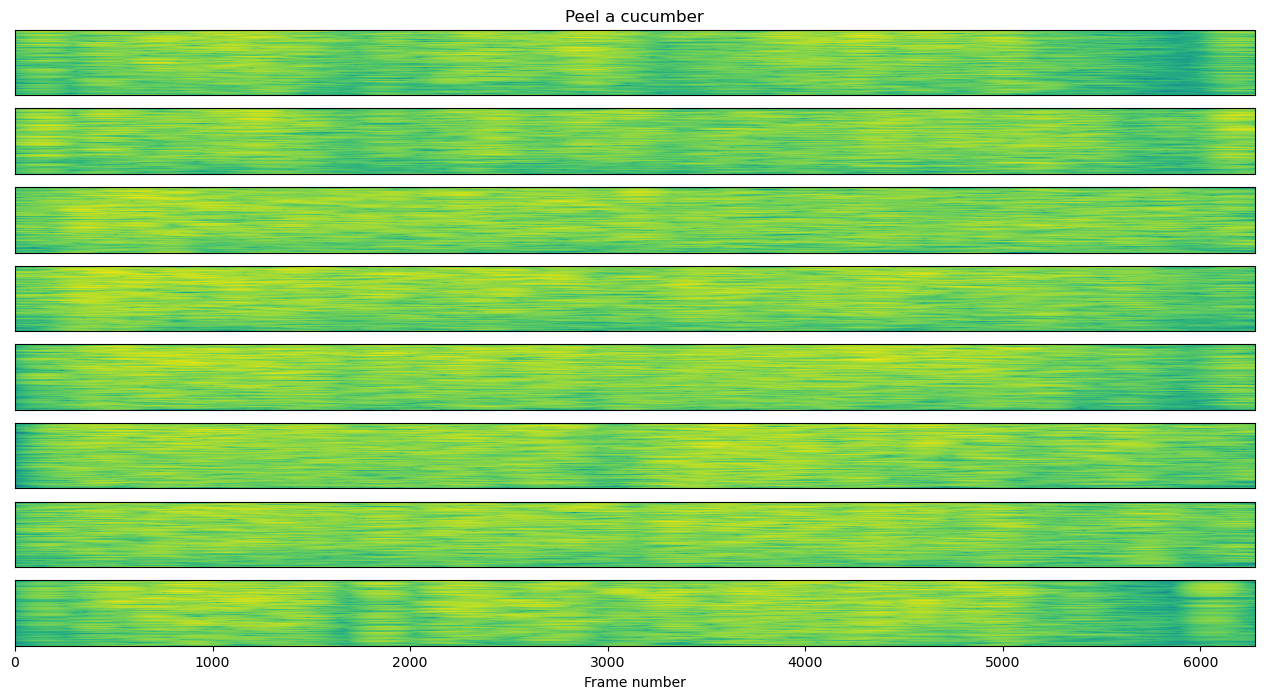

In [98]:
freq = compute_spectrogram(signal, title)

In [100]:
# Codice per creare una matrice che rappresenta l'EMG di un braccio per una clip

resampler = T.Resample(160, math.floor(256/(dur/5)))

clip = []
for i in range(8):
    clip_channel = freq[i]
    clip_channel = resampler(clip_channel[:, 0:dur_clip])
    # clip_channel = clip_channel[:, 0:dur_clip]
    clip.append(clip_channel)

clip = torch.stack(clip, dim=0)
clip.shape

torch.Size([8, 256, 253])